In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import CNNClassifier

In [2]:
prm_list = [
    # beta, file_name,
    [0.90, "conf/L32b090_"],
    [0.85, "conf/L32b085_"],
    [0.80, "conf/L32b080_"],
    [0.70, "conf/L32b070_"],
    [0.65, "conf/L32b065_"],
    [0.60, "conf/L32b060_"],
    [0.55, "conf/L32b055_"],
    [0.50, "conf/L32b050_"],
    [0.47, "conf/L32b047_"],
    [0.42, "conf/L32b042_"],
    [0.40, "conf/L32b040_"],
    [0.35, "conf/L32b035_"],
    [0.30, "conf/L32b030_"],
    [0.25, "conf/L32b025_"],
    [0.20, "conf/L32b020_"],
    [0.15, "conf/L32b015_"],
    [0.10, "conf/L32b010_"],
    [0.05, "conf/L32b005_"],
    [0.00, "conf/L32b000_"]
]
# beta19 x conf100 = 1900 data

In [3]:
# for beta in ["090", "040", "000"]:
#     for iconf in range(2):
#         print("beta =", beta)
#         file = f"conf/L32b{beta}_{iconf}.npy"
#         sc = np.load(file)
#         plt.imshow(sc, cmap='gray')
#         plt.show()

In [4]:
nconf = 100  # The number of configurations per beta
betacr = 0.440686  # critical temp for 2d ising

data = []
labels = []
betas = []
nprm = len(prm_list)
for ibeta in range(nprm):
    beta = prm_list[ibeta][0]
    fname = prm_list[ibeta][1]
    for itrj in range(nconf):
        npsc = np.load(f"{fname}{itrj}.npy")
        data.append(npsc)
        if beta > betacr:
            labels.append(1)
        else:
            labels.append(0)
        betas.append(beta)
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
labels = torch.tensor(labels, dtype=torch.float32)
train_data = data[0::2]
train_labels = labels[0::2]
train_betas = betas[0::2]
val_data = data[1::2]
val_labels = labels[1::2]
val_betas = betas[1::2]

/var/folders/pt/19z35k5s1x76pkdz1df1mnqm0000gn/T/ipykernel_17474/3654443758.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)


In [5]:
print("train_data.shape = ", train_data.shape)
print("train_labels.shape = ", train_labels.shape)
print("val_data.shape = ", val_data.shape)

train_data.shape =  torch.Size([950, 1, 32, 32])
train_labels.shape =  torch.Size([950])
val_data.shape =  torch.Size([950, 1, 32, 32])


In [6]:
train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=10, shuffle=True)
valid_loader = DataLoader(TensorDataset(val_data, val_labels), batch_size=10, shuffle=False)

In [7]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
epochs = 10
losses = []
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.type(torch.long))
        loss.backward()
        optimizer.step()
    
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            valid_loss += criterion(output, target.type(torch.long)).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    losses.append(valid_loss)
    print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {100. * correct / len(valid_loader.dataset)}%')
print("done.")
torch.save(model, "2d_Ising_model_classifier.pth")

Epoch: 1, Validation loss: 0.03319080393565328, Accuracy: 99.26315789473684%
Epoch: 2, Validation loss: 0.0048582681176646296, Accuracy: 99.57894736842105%
Epoch: 3, Validation loss: 0.0009955347734908165, Accuracy: 99.78947368421052%
Epoch: 4, Validation loss: 0.0003856817774889826, Accuracy: 99.89473684210526%
Epoch: 5, Validation loss: 0.00030897652848722895, Accuracy: 99.78947368421052%
Epoch: 6, Validation loss: 0.0003689231167184129, Accuracy: 99.89473684210526%
Epoch: 7, Validation loss: 0.00037644134582485273, Accuracy: 99.89473684210526%
Epoch: 8, Validation loss: 0.0003700066528602189, Accuracy: 99.89473684210526%
Epoch: 9, Validation loss: 0.0003743046505229212, Accuracy: 99.89473684210526%
Epoch: 10, Validation loss: 0.00036503093312594996, Accuracy: 99.89473684210526%
done.


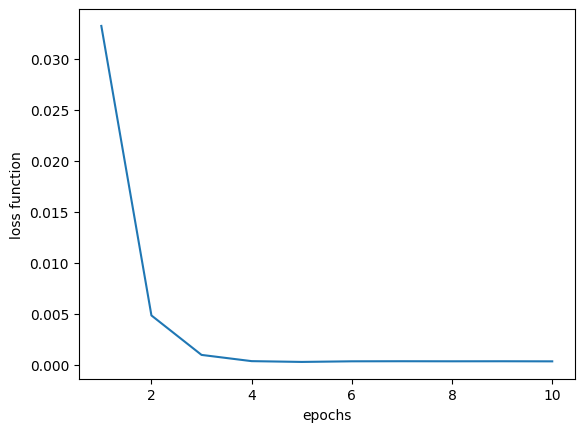

In [9]:
plt.xlabel('epochs')
plt.ylabel('loss function')
plt.plot(np.arange(1, epochs+1), losses)
plt.show()

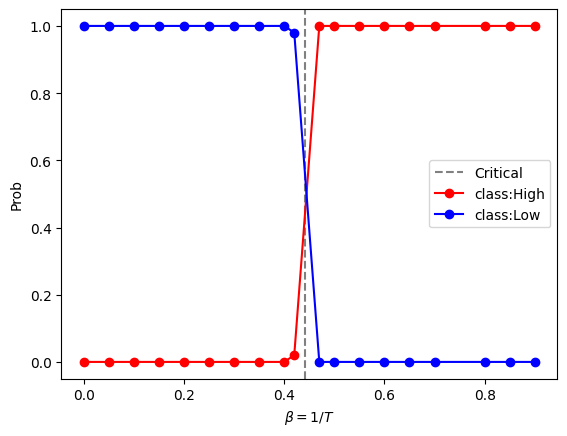

In [10]:
xs = []
y1s = []
y2s = []
Ndatamax = 950
Nsameclass = 50
for j in range(0, Ndatamax, Nsameclass):
    result = model(val_data[j:j+Nsameclass])
    x = val_betas[j]
    y1 = np.mean(result.argmax(dim=1, keepdim=True).detach().numpy().copy())
    y2 = 1 - np.mean(result.argmax(dim=1, keepdim=True).detach().numpy().copy())
    xs.append(x)
    y1s.append(y1)
    y2s.append(y2)
    # print(x, y1, y2)
plt.axvline(x=0.440686, ymin=0, ymax=1, ls="dashed", color="gray", label="Critical")
plt.plot(xs, y1s, label="class:High", marker="o", color="red")
plt.plot(xs, y2s, label="class:Low", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$\beta=1/T$")
plt.ylabel(r"Prob")
plt.show()